# 1. Load Data

In [3]:
import pandas as pd
from functools import reduce
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

In [4]:
# for processing dummy variable on ['genres', 'categories', 'tags']
def get_dummies(df, cols):
    dum_cols = []
    for col in cols: 
        dummy = df[col].str.get_dummies(sep=',')
        column_name_map = {i: col + '_' + i for i in dummy.columns.values}
        dummy = dummy.rename(columns=column_name_map)
        df = pd.concat([df, dummy], axis=1)
        df = df.drop(labels=[col],axis=1)
        dum_cols += list(dummy.columns.values)
    return df, dum_cols

In [5]:
# for getting dummy fields based on dates
def get_dummies_date(df, col, feats): 
    date_cols = []
    for feat, field in feats:
        df[col + '_' + feat] = field
        dummy = df[col + '_' + feat].astype(str).str.get_dummies()
        column_name_map = {i: col + '_' + feat + i for i in dummy.columns.values}
        dummy = dummy.rename(columns=column_name_map)
        df = pd.concat([df, dummy], axis=1)
        date_cols += list(dummy.columns.values)
    return df, date_cols

In [6]:
# engineer dates
def enrich_date(df, col):
    df[col] = pd.to_datetime(df[col])
    df[col] = df[col].fillna(df[col].min() + (df[col] - df[col].min()).mean())
    df, date_cols = get_dummies_date(df, col, [
        ('dayofweek', df[col].dt.dayofweek), ('month', df[col].dt.month)])
    return df, date_cols

In [7]:
# loss function
def rmse(y, y_pred):
    return np.sqrt(np.mean((y_pred - y)**2))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
from sklearn.model_selection import cross_val_score, GridSearchCV


In [8]:

def get_meaningful_cols(df, dum_cols):
    return df[dum_cols].columns[(df[dum_cols] == 1).any(axis=0)]

In [9]:
def to_datetime(dfs, cols):
    for df in dfs:
        for c in cols:
            df[c] = pd.to_datetime(df[c])
    return dfs

In [10]:
def normalize_price(dfs, df_all, price_th):
    price_th = 200000
    px_mean = df_all.price[df_all.price <= price_th].mean()
    for df in dfs:
        df.price = np.where(df.price > price_th, px_mean, df.price)
    mm = MinMaxScaler()
    df_all[['price']] = mm.fit_transform(df_all[['price']])
    for df in dfs:
        df[['price']] = mm.transform(df[['price']])
    return dfs

In [11]:
def normalize_is_free(dfs):
    for df in dfs:
        df['is_free'] = np.where(df.is_free == True, 1, 0)
    return dfs

In [12]:
def engineer_reviews(dfs, df_all): 
    mean_pos_rev = df_all['total_positive_reviews'].mean()
    mean_neg_rev = df_all['total_negative_reviews'].mean()
    for df in dfs:
        df['total_positive_reviews'] = df['total_positive_reviews'].fillna(mean_pos_rev)
        df['total_negative_reviews'] = df['total_negative_reviews'].fillna(mean_neg_rev)
    mm_cols = ['total_positive_reviews', 'total_negative_reviews']
    mm = MinMaxScaler()
    df_all[mm_cols] = mm.fit_transform(df_all[mm_cols])
    for df in dfs:
        df[mm_cols] = mm.transform(df[mm_cols])
    return dfs

In [13]:
# get dummy variables expanded by ['genres', 'categories', 'tags'], and get the fields that are overlapped between train and test
def get_dummy_category(df_all, dftr, dfts): 
    df_all, dum_cols = get_dummies(df_all, ['genres', 'categories', 'tags'])
    meaningful_dums = set(get_meaningful_cols(df_all[df_all.is_test == 1], dum_cols)).intersection(
        get_meaningful_cols(df_all[df_all.is_test == 0], dum_cols))
    no_use_dums = set(dum_cols) - meaningful_dums
    df_all = df_all.drop(columns=no_use_dums)
    dftr, dum_cols = get_dummies(dftr, ['genres', 'categories', 'tags'])
    no_use_dums = set(dum_cols) - meaningful_dums
    dftr = dftr.drop(columns=no_use_dums)
    dfts, dum_cols = get_dummies(dfts, ['genres', 'categories', 'tags'])
    no_use_dums = set(dum_cols) - meaningful_dums
    dfts = dfts.drop(columns=no_use_dums)
    return df_all, dftr, dfts, meaningful_dums

In [14]:
def get_date_dums(df_all, dftr, dfts): 
    meaningful_dates = []
    date_fields = ['purchase_date']
    for date_field in date_fields:
        df_all, date_dums = enrich_date(df_all, date_field)
        meaningful_date_set = set(get_meaningful_cols(df_all[df_all.is_test == 1], date_dums)
                              ).intersection(get_meaningful_cols(df_all[df_all.is_test == 0], date_dums))
        meaningful_dates += list(meaningful_date_set)
        no_use_dums = set(date_dums) - meaningful_date_set
        df_all = df_all.drop(columns=no_use_dums)
        dftr, date_dums = enrich_date(dftr, date_field)
        no_use_dums = set(date_dums) - meaningful_date_set
        dftr = dftr.drop(columns=no_use_dums)
        dfts, date_dums = enrich_date(dfts, date_field)
        no_use_dums = set(date_dums) - meaningful_date_set
        dfts = dfts.drop(columns=no_use_dums)
    return df_all, dftr, dfts, meaningful_dates

In [15]:
# loading data and engieer the features
def load_data():
    dftr = pd.read_csv('train.csv')
    dftr['is_test'] = 0
    # only filter in the valid training sample, i.e. playtime > 0
    #dftr = dftr[dftr.playtime_forever > 0]
    dfts = pd.read_csv('test.csv')
    dfts['playtime_forever'] = 0
    dfts['is_test'] = 1
    df = pd.concat([dftr, dfts], axis=0, ignore_index=True, sort=False)

    # convert date field from obj to date
    df, dftr, dfts = to_datetime((df, dftr, dfts), ('purchase_date', 'release_date'))
    # price normalize
    price_th = 200000
    df, dftr, dfts = normalize_price((df, dftr, dfts), df, price_th)
    # free
    df, dftr, dfts = normalize_is_free((df, dftr, dfts))
    # reviews
    df, dftr, dfts = engineer_reviews((df, dftr, dfts), df)
    # dummy cols
    df, dftr, dfts, category_dums = get_dummy_category(df, dftr, dfts)
    # purchase_date
    df, dftr, dfts, date_dums = get_date_dums(df, dftr, dfts)
    return df, dftr, dfts, list(category_dums) + list(date_dums)

In [16]:
def describe_data(df):
    print('====================== shape ======================')
    print(df.shape)
    print('====================== schema ======================')
    print(df.dtypes)


# 2. Inspect Data

In [17]:
df, dftr, dfts, dums = load_data()
print(df.shape, dftr.shape, dfts.shape)
describe_data(df)


(447, 296) (357, 296) (90, 296)
====================== shape ======================
(447, 296)
====================== schema ======================
id                                                int64
playtime_forever                                float64
is_free                                           int64
price                                           float64
purchase_date                            datetime64[ns]
release_date                             datetime64[ns]
total_positive_reviews                          float64
total_negative_reviews                          float64
is_test                                           int64
genres_Action                                     int64
genres_Adventure                                  int64
genres_Casual                                     int64
genres_Early Access                               int64
genres_Free to Play                               int64
genres_Gore                                       int64
genres_Indie

In [18]:
df.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('<M8[ns]')], dtype=object)

In [19]:
dftr[dftr.isna().any(axis=1)]

,id,playtime_forever,is_free,price,purchase_date,release_date,total_positive_reviews,total_negative_reviews,is_test,genres_Action,...,purchase_date_month11,purchase_date_month12,purchase_date_month2,purchase_date_month3,purchase_date_month4,purchase_date_month5,purchase_date_month6,purchase_date_month7,purchase_date_month8,purchase_date_month9


In [20]:
dfts[dfts.isna().any(axis=1)]

,id,is_free,price,purchase_date,release_date,total_positive_reviews,total_negative_reviews,playtime_forever,is_test,genres_Action,...,purchase_date_month11,purchase_date_month12,purchase_date_month2,purchase_date_month3,purchase_date_month4,purchase_date_month5,purchase_date_month6,purchase_date_month7,purchase_date_month8,purchase_date_month9


In [21]:
key = []
value = []
for c in df.columns.values:
    if df[c].dtypes == np.dtype('int64') or df[c].dtypes == np.dtype('float64'):
        key.append(c)
        value.append(dftr[c].corr(dftr.playtime_forever))
corr = pd.DataFrame.from_dict({'col': key, 'corr': value})
corr.sort_values(['corr'], ascending=False)[0:40]


,col,corr
1,playtime_forever,1.000000
4,total_positive_reviews,0.394506
5,total_negative_reviews,0.392950
85,tags_Co-op,0.223363
90,tags_Crafting,0.213636
202,tags_PvP,0.207131
183,tags_Online Co-Op,0.192023
22,categories_Co-op,0.185373
257,tags_Turn-Based Combat,0.181008
280,purchase_date_dayofweek6,0.174142


# 3. Separating label from features

In [22]:
key_cols = corr.sort_values(['corr'], ascending=False)['col'][1:101].values

dftr = dftr.sample(frac=1).reset_index(drop=True)

dfx = dftr[key_cols]
dfy = dftr['playtime_forever']
nfx = dfts[key_cols]

print(nfx.shape, dfx.shape, dfy.shape)

(90, 100) (357, 100) (357,)


# 4. Ranom Forest Training

In [23]:
train = dfx.shape[0] // 5 * 4
tr_X, ts_X, tr_y, ts_y = dfx[0:train], dfx[train:], dfy[0:train], dfy[train:]
tr_X.shape, ts_X.shape, tr_y.shape, ts_y.shape

((284, 100), (73, 100), (284,), (73,))

In [24]:
#est = AdaBoostRegressor(random_state=0, n_estimators=1000, learning_rate=0.001, loss='linear')
est = RandomForestRegressor(max_depth=200, random_state=0,
    n_estimators=10000, n_jobs=4)

est.fit(tr_X, tr_y)
y_pred = est.predict(ts_X)
rmse(y_pred, ts_y)

6.963090292111098

# 5. cross validation

In [26]:

est = RandomForestRegressor(max_depth=200, random_state=0,
    n_estimators=10000, n_jobs=4)
scores = cross_val_score(est, dfx, dfy, cv=5, scoring=rmse_scorer)
a_scores = np.array(scores)
print(a_scores)
print(np.round(np.mean(a_scores), 2), np.round(np.std(a_scores), 2))



KeyboardInterrupt: 

# 6. predict

In [27]:
est = RandomForestRegressor(max_depth=200, random_state=0,
    n_estimators=10000, n_jobs=4)
est.fit(dfx, dfy)
nfy = est.predict(nfx)
dfts['playtime_forever'] = nfy

In [28]:
nfy_pred = dfts[['id', 'playtime_forever']]
nfy_pred.describe()


,id,playtime_forever
count,90.000000,90.000000
mean,44.500000,3.118107
std,26.124701,5.112585
min,0.000000,0.084523
25%,22.250000,0.816586
50%,44.500000,1.338190
75%,66.750000,2.787185
max,89.000000,31.937217


In [29]:
nfy_pred

,id,playtime_forever
0,0,2.065012
1,1,3.079923
2,2,1.334695
3,3,1.480293
4,4,7.337098
5,5,1.178175
6,6,2.669062
7,7,0.312467
8,8,6.003985
9,9,1.567648


# 7. Verify and save

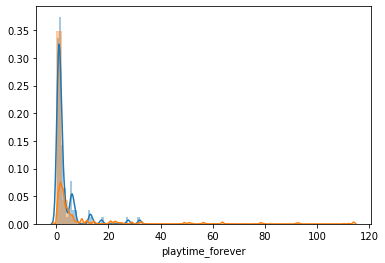

In [30]:
sns.distplot(nfy_pred['playtime_forever'])
sns.distplot(dftr['playtime_forever'])

In [31]:
nfy_pred.to_csv('submission.csv', index=False)